# 546 (Optimization for Learning and Control) hw3

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use your preferred computational toolkit -- upload the **commented** sourcecode alongside your writeup (e.g. the .ipynb file).

You are welcome to consult research articles and other materials -- upload a .pdf of the article alongside your writeup and indicate which references were used where in the writeup.

# Markov decision process (MDP) (14 pts)

Let $(X,U,P,c)$ be an MDP:

* $X$ is a finite set of $N$ *states*;
* $U$ is a finite set of $M$ *actions*;
* $P:X\times U\rightarrow \Delta(X)$ specifies transition probabilities;
* $C:X\times U\rightarrow \mathbb{R}$ specifies transition cost.

Recall that $\Delta(S) = \{p : S \rightarrow [0,1] : \sum_{s\in S} p(s) = 1\}$ is the set of probability distributions over the finite set $S$.

In [151]:
import numpy as np
import pylab as plt
from scipy import linalg as la
import scipy.stats as stats
%matplotlib inline
import matplotlib.pylab as plt
import control as ctrl

a. *Implement an algorithm that generates a random MDP given finite sets $X$ and $U$ (i.e. let $N = |X|$, $M = |U|$ be parameters that are easy to vary, and generate $P$ and $c$ randomly).*

In [2]:
#generate random MDP (X,U,P,C)

#X is a set of N sample space (finite set)
N = 3
X = list(range(N))

#U is a set of M sample space (finite set)
M = 2
U = list(range(M))

#P is transition probabilities
P_ = np.abs(np.random.randn(N,M,N))
P = P_ / np.sum(P_, axis=2)[:,:,np.newaxis] #sum to be 1 over X
P

#C is a random cost 
C = np.abs(np.random.randn(N,M,N))

P,C

(array([[[0.61889574, 0.06055109, 0.32055317],
         [0.119407  , 0.59471483, 0.28587817]],
 
        [[0.40714309, 0.01623439, 0.57662252],
         [0.15925192, 0.57754798, 0.2632001 ]],
 
        [[0.53516512, 0.08788711, 0.37694777],
         [0.48491681, 0.35919243, 0.15589076]]]),
 array([[[0.03392282, 0.27984978, 0.15380595],
         [1.31862887, 0.46752891, 0.22215007]],
 
        [[0.7323449 , 0.94885829, 0.80286296],
         [0.92307523, 0.78807328, 0.69107989]],
 
        [[0.15182086, 1.27461569, 0.3929979 ],
         [1.88920608, 0.76343725, 1.56268295]]]))

b. *Implement an algorithm that simulates an MDP (i.e. write a function that inputs transition probabilities $P$, cost $c$, initial state distribution $p_0$, policy $\pi:X\rightarrow\Delta(U)$, and time horizon $t$ and returns the state distribution $p_t$).*

In [18]:
#p0 is a random initila state distribution
p0_ = np.abs(np.random.randn(N)) #1x3
p0 = p0_ / np.sum(p0_)

#pi is policy with sum=1 over U 
PI_ = np.abs(np.random.randn(N,M)) #3x2
PI = PI_ / np.sum(PI_,axis=1)[:,np.newaxis]


$$p(x^{+}) = \sum_{x\in X} p(x) (\sum_{u \in U} \pi (u|x) P(x^+|x,u)) .$$

In [37]:
def MP(X,U,P,p0,PI, T = 1): #markov process
    p_ = [p0]
    for t in range(T):
        p_prev = p_[-1]
        p_next = np.zeros((N))
        for xp in X:
            p_next[xp] = np.sum( [p_prev[x]* np.sum([PI[x,u]*P[x,u,xp] for u in U]) for x in X]) #x is x, xp is x+
        p_.append(p_next)
    return p_

c. *Test your algorithm from (b.) (i.e. design one or more tests, explain why these tests are exhaustive, and provide summary statistics and/or visualizations that convince a skeptical reader that your algorithm is correct).*

In [40]:
T = 50

for i in range(3): # 3 experiments with different initial cond p0
    p0_ = np.abs(np.random.randn(N)) #1x3
    p0 = p0_ / np.sum(p0_)

    p_ = MP(X,U,P,p0,PI, T = T) #100 
    print(p_[-1]) #final p after T iterations



[0.41251166 0.2274269  0.36006144]
[0.41251166 0.2274269  0.36006144]
[0.41251166 0.2274269  0.36006144]


Let us now consider the problem of minimizing the infinite-horizon discounted cost
$$c = \sum_{t=0}^\infty \gamma^t C(x_t,u_t),$$
where $\gamma\in(0,1)$ is a ***discount factor***.

Any policy $\pi : X\rightarrow\Delta(U)$ has an associated ***value*** $v^\pi : X\rightarrow\mathbb{R}$ defined by
$$\forall x\in X : v^\pi(x) = E[c \mid x = x_0]$$
that satisfies the *Bellman equation*
$$\forall x\in X : v^\pi(x) = \sum_{u\in U}\pi(u|x)\sum_{x^+\in X} P(x^+|x,u)\left[C(x,u) + \gamma \cdot v^\pi(x^+)\right].$$

d. *Noting that $v^\pi$ appears linearly in this Bellman equation, implement a ***policy evaluation*** algorithm that computes $v^\pi$ using linear algebra (i.e. determing $L$ and $b$ such that $L v^\pi = b$ and use this equation to solve for $v^\pi$).*

$$ v^{\pi}(x^+) = L^{-1} b$$

where $$L(x,x^+) = \delta(x,x^+) - \sum_{u\in U} \gamma\cdot \pi(u|x)\cdot P(x^+|x,u),$$
$$b(x) = \sum_{x^+\in X}\sum_{u\in U} \pi(u|x)\cdot P(x^+|x,u)\cdot C(x,u)$$

Note that the "C" here is the "L" in lecture note, where $L: X \times U \rightarrow \Delta(X)$

In [105]:
def policy_evaluation(gamma,X,U,P,C,PI): #policy evaluation: given the current pi, find the next v
    b = np.zeros((N))
    I = np.identity(N)
    L = I

    for x in X:
        b[x] = np.sum( [[PI[x,u]*P[x,u,xp]*C[x,u,xp] for u in U] for xp in X] )  #x is x, xp is x+
        L = I - [np.sum([gamma*PI[x,u]*P[x,u,xp] for u in U]) for xp in X]
    v_pi = np.dot(la.inv(L),b)

    return v_pi
    

e. *Test your policy evaluation algorithm from (d.) (i.e. design one or more tests, explain why these tests are exhaustive, and provide summary statistics and/or visualizations that convince a skeptical reader that your algorithm is correct).*

In [106]:
gamma = np.random.rand()
v = policy_evaluation(gamma,X,U,P,C,PI) #value function: value of the policy for each state
v

array([0.71870815, 1.18116476, 1.00467199])

f. *Using your policy evaluation algorithm from (d.), implement ***value iteration*** and ***policy iteration*** algorithms.*

g. *Test your value iteration and policy iteration algorithms from (f.) (i.e. design one or more tests, explain why these tests are exhaustive, and provide summary statistics and/or visualizations that convince a skeptical reader that your algorithm is correct).*

$$u^*(x)= \text{argmin}_{ u\in U}\left(\sum_{x^+\in X} P(x^+|x,u)\left[C(x,u) + \gamma \cdot v^\pi(x^+)\right]\right)$$
And then we update policy by $$\pi(u|x)=\delta(u,u^*(x))$$

In [141]:
#policy iteration: 

#(1) policy evaluation: given any initial policy pi0, find next value of the policy v1

#(2) greedy_update: improve policy with greedy update pi+ (i.e. make the direction of next policy "1")

def greedy_update(gamma,X,U,P,C,v_pi):
    pi = np.zeros((N,M))
    for x in X:
        index = np.argmin( [[P[x,u,xp]*(C[x,u,xp] + gamma*v_pi[xp]) for xp in X] for u in U])
        pi[x,index] = 1.
    return pi

def policy_iteration(gamma,X,U,P,C,PI0): #finite number of iterations
    PI_ = [PI0]
    v1 = policy_evaluation(gamma,X,U,P,C,PI0)
    v_ = [v1]

    while len(v_)<2 or not(np.allclose(v_[-1],v_[-2])): # loop until v_pi converges
        PI_.append( greedy_update(gamma,X,U,P,C,v_[-1]) )
        v_.append( policy_evaluation(gamma,X,U,P,C,PI_[-1]) )
        
    return PI_, v_

# def policy_iteration(gamma,X,U,P,C,PI0): #finite number of iterations
#     PI_ = [PI0]
#     v_ = [0.]

#     while len(v_)<2 or not(np.allclose(v_[-1],v_[-2])): # loop until v_pi converges
#         v_.append( policy_evaluation(gamma,X,U,P,C,PI_[-1]) )
#         PI_.append( greedy_update(gamma,X,U,P,C,v_[-1]) )
        
#     return PI_, v_


In [142]:
PI0 = PI
PI_, v_ = policy_iteration(gamma,X,U,P,C,PI0)
PI_,v_

([array([[0.44602491, 0.55397509],
         [0.82918878, 0.17081122],
         [0.76210803, 0.23789197]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]])],
 [array([0.71870815, 1.18116476, 1.00467199]),
  array([1.128689  , 1.41372518, 2.06361775]),
  array([1.128689  , 1.41372518, 2.06361775])])

$$v^\pi(x) = \sum_{u\in U}\pi(u|x)\sum_{x^+\in X} P(x^+|x,u)\left[C(x,u) + \gamma \cdot v^\pi(x^+)\right]$$

In [143]:
#value iteration: v+ = Tv, iterate until v converges 

#(1) update_value : given any initial policy pi0 and initial value of the policy v0, find the next value v1

#(2) greedy_update: from v1, improve policy with greedy update pi1 (i.e. make the direction of next policy "1")
    
def update_value(gamma,X,U,P,C,PI,v_pi):
    v_pi_next = np.zeros((N))
    for x in X:
        v_pi_next[x] = np.sum([PI[x,u] * np.sum([P[x,u,xp]*(C[x,u,xp] + gamma*v_pi[xp]) for xp in X]) for u in U])
    return v_pi_next
    
def value_iteration(gamma,X,U,P,C,PI0,maxiter=100): #infinite number of iteraitons
    PI_ = [PI0]
    v0 = np.zeros((N))
    v_ = [v0]

    while len(v_)<2 or not(np.allclose(v_[-1],v_[-2])) and len(v_) < maxiter: # loop until v_pi converges or reaches max iteration
        v_.append( update_value(gamma,X,U,P,C,PI_[-1],v_[-1]))
        PI_.append( greedy_update(gamma,X,U,P,C,v_[-1]))
        
    return PI_, v_

In [144]:
PI0 = PI
PI_, v_ = value_iteration(gamma,X,U,P,C,PI0,maxiter=100)
PI_,v_

([array([[0.44602491, 0.55397509],
         [0.82918878, 0.17081122],
         [0.76210803, 0.23789197]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  array(

## linear quadratic regulation (6 pts)

Consider the linear-quadratic regulation (LQR) problem for the discrete-time linear time-invariant system
$$x^+ = A x + B u$$
with infinite-horizon cost
$$c(x,u) = \frac{1}{2}\sum_{t=0}^\infty x^T Q x + u^T R u \ dt$$
where  $Q = Q^T > 0$ and $R = R^T > 0$.  We know that the optimal policy is linear in state, 
$$u = - K x,$$
where $K = (R + B^T Y B)^{-1} (B^T Y A)$ and $Y$ satisfies the discrete algebraic Riccati equation
$$Y = A^T Y A - (A^T Y B)(R + B^T Y B)^{-1}(B^T Y A) + Q.$$

For this problem, we'll consider a one-dimensional system, so $x,u\in\mathbb{R}$, with the values $A, B, Q, R = 1$.

If the state distribution starts out Gaussian, 
$$x \sim \mathcal{N}(\xi, \Sigma),$$
and we apply zero input but add a state disturbance with zero mean and covariance $W$, then (so long as the disturbance is uncorrelated with the state) the state distribution after one step is Gaussian:
$$x^+ \sim \mathcal{N}(A\xi, A\Sigma A^T + W),$$
i.e. the covariance gets updated via
$$\Sigma^+ = A\Sigma A^T + W.$$
Since $A$ is stable, so long as $W$ is constant, this iteration will converge to a solution of the Lyapunov equation
$$S = A S A^T + W.$$
Also, since $A$ is stable, the steady-state mean is zero, thus we can determine the steady-state distribution in closed-form:
$$\lim_{t\rightarrow\infty} x(t) \sim \mathcal{N}(0, S).$$

In this problem, you'll make use of the facts above to build a finite MDP that approximates the LQR, solve the MDP using your algorithms from the previous problem, then make use of the facts above again to validate the solution you've obtained.

a. *Construct a finite MDP by discretizing the state and action spaces of the linear system and computing transition probabilities and transition costs to obtain  $(X,U,P,C)$ where:*

* $X$ is a finite set of $N$ *states*;
* $U$ is a finite set of $M$ *actions*;
* $P:X\times U\rightarrow \Delta(X)$ specifies transition probabilities;
* $C:X\times U\times X\rightarrow \mathbb{R}$ specifies transition costs.

In [146]:
n = 1; m = 1
A = np.array([[0.99]]) # to avois system becomes unstable
B = Q  = R = np.array([[1.0]])

In [156]:
Y = la.solve_discrete_are(A,B,Q,R)
K, Y, E = ctrl.dlqr(A, B, Q, R)
K, Y

(array([[0.60976745]]), array([[1.60366977]]))

In [164]:
W = 2.
S = la.solve_discrete_lyapunov(A,W) #np.dot(A, np.dot( S, A.T )) + W
S 

array(100.50251256)

In [167]:
15*2*(np.random.rand(N,n)-.5) 

array([[ -3.58259055],
       [ -6.84696864],
       [-14.48965499]])

In [ ]:
def MDP_LQR(N,M,n,m): #x , u \in R, N and M are number of sample space
    X_index = list(range(N))
    U_index = list(range(M))
    X = np.random.rand(N,n)
    U = np.random.rand(M,m)
    P = np.zeros((N,M,N))
    C = np.zeros((N,M,N))

    for xi in X_index:
        for ui in U_index:
            x_next = A*X[xi] + B*U[ui] #deterministic
            P[xi,ui] = stats.multivariate_normal.pdf(X[xi],mean=x_next,cov=W)
            C[xi,ui] = 0.5* ( np.dot(np.dot(x,Q),x) + np.dot(np.dot(u,R),u) )

    P = P / P.sum(axis=2)[...,np.newaxis]  #normalization to make sum prob = 1

    return X,U,P,C


In [194]:
np.random.rand(N,n)

array([[0.03743565],
       [0.10168145],
       [0.26802435],
       [0.95671837],
       [0.79452724],
       [0.29960041],
       [0.09648368],
       [0.8699733 ],
       [0.8019709 ],
       [0.64070896]])

In [189]:
N,M = 10,5                         # number of discrete states, actions
X = 15*2*(np.random.rand(N,n)-.5)    # discrete states
U = 15*2*(np.random.rand(M,m)-.5)    # discrete actions
X[0],U[0] = 0,0                      # include 0 as a state and an action

P = np.nan*np.zeros((N,M,N))         # initialize transition probability
C = np.nan*np.zeros((N,M,N))         # initizlize transition cost



In [190]:
x_next = np.dot(x,A.T)+np.dot(u,B.T)
stats.multivariate_normal.pdf(X,mean=x_next,cov=W)

array([7.68807366e-07, 2.59310414e-15, 2.50573978e-01, 2.31081283e-48,
       1.50448869e-01, 6.95589675e-24, 1.53030630e-02, 4.11323420e-20,
       1.59069814e-01, 1.60176351e-01])

In [ ]:
for x_idx,x in enumerate(X):              # loop over initial discrete state
    for u_idx,u in enumerate(U):            # loop over discrete actions
        x_next = np.dot(x,A.T)+np.dot(u,B.T)  # the deterministic next state
        P[x_idx,u_idx] = stats.multivariate_normal.pdf(X,mean=x_next,cov=W)
        C[x_idx,u_idx] = 0.5 *(np.dot(np.dot(x,Q),x) + np.dot(np.dot(u,R),u))

In [179]:
# (4) Define MDP-LQR System
def Create_MDP_LQR(M,N,m,n):
    X = 15*2*(np.random.rand(N,n)-.5)    # discrete states
    U = 15*2*(np.random.rand(M,m)-.5)    # discrete actions
    X[0],U[0] = 0,0                      # include 0 as a state and an action

    P = np.nan*np.zeros((N,M,N))         # initialize transition probability
    C = np.nan*np.zeros((N,M,N))         # initizlize transition cost

    for x_idx,x in enumerate(X):              # loop over initial discrete state
      for u_idx,u in enumerate(U):            # loop over discrete actions
        x_next = np.dot(x,A.T)+np.dot(u,B.T)  # the deterministic next state
        P[x_idx,u_idx] = stats.multivariate_normal.pdf(X,mean=x_next,cov=W)
        C[x_idx,u_idx] = 0.5 *(np.dot(np.dot(x,Q),x) + np.dot(np.dot(u,R),u))

    P = P / P.sum(axis=2)[...,np.newaxis] # renormalize probabilities

    assert not np.any(np.isnan(P)),"all probabilities defined"
    assert not np.any(np.isnan(C)),"all costs defined"

    return X,U,P,C




In [ ]:
N,M = 1000,5                         # number of discrete states, actions
X,U,P,C = Create_MDP_LQR(M,N,m,n)   

In [180]:
X

array([[ 0.00000000e+00],
       [-1.40472322e+01],
       [ 9.11479224e+00],
       [ 1.09198205e+01],
       [ 6.47378364e+00],
       [ 1.20711256e+00],
       [-2.90250541e-01],
       [ 6.57281807e+00],
       [ 1.04966020e+01],
       [ 1.45604889e+01],
       [ 1.02811680e+01],
       [ 1.46389054e+01],
       [-6.40586787e+00],
       [-1.14053933e+01],
       [-1.87970384e+00],
       [-4.59786289e+00],
       [-1.14029853e+01],
       [-9.40702502e+00],
       [-7.72663896e+00],
       [-3.78722411e+00],
       [ 9.80496795e+00],
       [-7.30521272e+00],
       [ 1.26679137e+01],
       [-4.11610267e+00],
       [-8.92472072e+00],
       [ 1.36816291e+01],
       [ 7.21347375e+00],
       [-5.59940033e+00],
       [-1.28838428e+01],
       [-5.42775043e+00],
       [-1.29942465e+01],
       [-1.22259974e+01],
       [-9.38352991e+00],
       [-1.00577891e+01],
       [-1.26773455e+01],
       [-5.37809295e+00],
       [ 1.34706676e+01],
       [ 1.04336632e+01],
       [-1.1

(array([118., 103.,  99.,  93.,  77., 111.,  92., 101.,  96., 110.]),
 array([-1.49954703e+01, -1.19979448e+01, -9.00041926e+00, -6.00289371e+00,
        -3.00536817e+00, -7.84262218e-03,  2.98968292e+00,  5.98720847e+00,
         8.98473401e+00,  1.19822596e+01,  1.49797851e+01]),
 <a list of 10 Patch objects>)

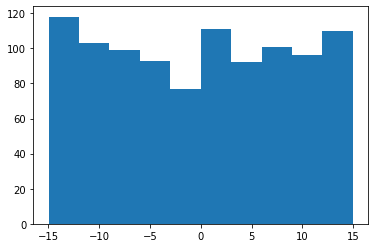

In [181]:
plt.hist(X)

b. *Compare the steady-state distribution of the MDP with the steady-state distribution of the linear system subject to zero-mean disturbance with covariance $W$.  Discuss how the comparison varies with respect to $|X|$.*

Now consider the problem of minimizing the infinite-horizon discounted cost
$$c = \sum_{t=0}^\infty \gamma^t C(x_t,u_t),$$
where $\gamma\in(0,1]$ is a *discount factor*.

The un-discounted case $\gamma = 1$ corresponds exactly to LQR; unfortunately, policy iteration won't converge when $\gamma = 1$!

c. *Compare the optimal value and control for the MDP obtained using value or policy iteration with the optimal value and control for the original LQR problem.  Discuss how the comparison varies with respect to $|X|$, $|U|$, and $\gamma$.*

# paper / project presentation (4 pts)

You will give a combined paper / project presentation during the final two weeks of class meetings.

The paper presentation constitutes 30% of the course grade.  

The project constitutes 50% of the course grade, with the project presentation constituting 1/5 of that portion, so 10% of the course grade.

The presentations will be evaluated according to a simple rubric:  ***what did we learn, and how do we know we learned it?***  Your goal should be to (i) teach us something new (i.e. not covered in the course) and (ii) provide simple examples or exercises we can use to assess our understanding.  You should endeavor to adopt the notation and terminology from lecture (this may require translation from source material), and all new concepts and techniques must be defined and explained.

Each presenter will be allotted 20min of lecture time, including answering questions that arise during or after the presentations -- ***there will be a hard stop after 20min***.  To satisfy this constraint while maximizing your expected grade, you should prepare < 10min of material for the paper portion of the presentation and < 5min of material for the project presentation.  (*Hint:* you probably need to prepare less material than you expect -- to calibrate, I encourage you to practice your presentations with a colleague who actively asks questions.)

a. *Update your availability in the shared document accessible via Canvas -> Collaborations.*

b. Specify whether you are planning a solo or group project -- if group, specify your group members.